In [9]:
"""Example of the optimization process for SGOOP.  Here we find the weights of cos(phi),sin(phi),cos(psi),sin(psi)
for alanine dipeptide in vacuum from a metadynamics trajectory.  We use the cos and sin of dihedral angles to avoid
inaccuracy caused by the discontinuity of angles (pi = -pi)."""
import sgoop
import reweight
import scipy.optimize as opt
import numpy as np
import time
import matplotlib.pyplot as plt
import kinetics as kin

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [10]:
def opti_func(rc):
    # function to be used in basinhopping. records function evaluations and returns -spectral gap
    global nfev
    nfev +=1
    p = reweight.reweight(rc)
    binned,rc_bin=sgoop.set_bins(rc,np.shape(p)[0],reweight.s_min,reweight.s_max) # Setting bins for maxcal
    return -sgoop.sgoop(rc,p,binned,rc_bin=rc_bin)

In [11]:
def print_fun(x, f, accepted):
    # printing progress during optimization
    global now,last,nfev,lastf
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

In [12]:
def temp_print_fun(x, f, accepted):
    # printing progress while determining the temperature
    global now,last,nfev,lastf,f_array,f_i
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev
    f_array[f_i]=-f
    f_i+=1

In [13]:
def sgoophopping(step=1,iterations=3):
    # basinhopping for 1 dimensional SGOOP
    global last,nfev,lastf,f_array,f_i
    
    f_array=np.zeros(50)
    f_i=0

    print('---------------------------------------------------------------------------')
    print('BEGINNING',sgoop.wells,'WELL TEMPERATURE OPTIMIZATION')
    print('---------------------------------------------------------------------------')

    # Finding temperature value
    start = time.time()
    last = start
    lastf = nfev = 0
    minimizer_kwargs = {"options": {"maxiter":10}}
    ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=50,T=.01,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=temp_print_fun)
    T_new=np.mean(np.abs(f_array[0:-1]-f_array[1:]))

    replicas=[None]*iterations

    for i in range(iterations):
        print('---------------------------------------------------------------------------')
        print('BEGINNING',sgoop.wells,'WELL RC OPTIMIZATION #',i+1)
        print('---------------------------------------------------------------------------')
        start = time.time()
        last = start
        lastf = nfev = 0
        minimizer_kwargs = {"options": {"maxiter":10}}
        ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=200,T=T_new,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
        replicas[i]=[ret.x,-ret.fun]

    replicas=np.asarray(replicas)
    soln=replicas[:,0][np.argmax(replicas[:,1])]
    soln/=soln[np.argmax(np.abs(soln))]
    p=sgoop.md_prob(soln)
    wells_found=kin.find_wells(p)
    return wells_found,soln

---------------------------------------------------------------------------
BEGINNING 2 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[ 0.826 -0.341 -0.080  0.679] with spectral gap 0.0082 accepted after  12 runs (0.052)
[ 0.132  0.087  0.051  0.263] with spectral gap 0.0041 declined after   6 runs (0.029)
[ 1.725  0.098  0.766  1.052] with spectral gap 0.0045 accepted after   6 runs (0.026)
[ 1.211  0.157  1.613  0.989] with spectral gap 0.0048 accepted after   6 runs (0.028)
[ 1.317  0.161  2.387  1.972] with spectral gap 0.0032 accepted after   6 runs (0.026)
[ 2.193  0.914  3.165  1.789] with spectral gap 0.0063 accepted after   6 runs (0.027)
[ 2.989  1.617  3.306  1.493] with spectral gap 0.0076 accepted after   6 runs (0.024)
[ 3.756  2.433  3.079  1.379] with spectral gap 0.0042 accepted after   6 runs (0.025)
[ 4.067  2.963  3.573  1.371] with spectral gap 0.0025 accepted after   6 runs (0.026)
[ 3.384  2.552  2.886  

[-0.644  0.981  1.847  1.610] with spectral gap 0.0095 declined after   6 runs (0.037)
[-0.482  1.595  1.408  1.464] with spectral gap 0.0034 declined after   6 runs (0.031)
[-0.818  1.041  1.216  2.765] with spectral gap 0.0048 declined after   6 runs (0.041)
[-0.846  2.292  2.216  2.842] with spectral gap 0.0116 declined after   6 runs (0.036)
[ 0.307  0.642  2.159  1.627] with spectral gap 0.0061 declined after   6 runs (0.045)
[ 0.465  2.001  1.876  2.722] with spectral gap 0.0113 declined after   6 runs (0.037)
[-0.141  2.312  2.131  1.458] with spectral gap 0.0016 declined after   6 runs (0.039)
[-0.802  2.018  1.464  1.446] with spectral gap 0.0051 declined after   6 runs (0.025)
[ 0.124  1.426  2.068  2.037] with spectral gap 0.0122 accepted after   6 runs (0.027)
[-0.337  0.967  2.324  2.565] with spectral gap 0.0070 declined after   6 runs (0.028)
[ 0.570  0.999  2.912  1.219] with spectral gap 0.0073 declined after   6 runs (0.023)
[ 0.508  1.722  2.473  2.812] with spectral

[-1.381  2.862  3.367  3.333] with spectral gap 0.0111 declined after   6 runs (0.027)
[ 0.076  3.130  4.112  2.449] with spectral gap 0.0035 declined after   6 runs (0.027)
[-1.025  2.121  3.604  2.273] with spectral gap 0.0113 accepted after   6 runs (0.031)
[-0.319  2.840  4.041  2.201] with spectral gap 0.0038 declined after   6 runs (0.027)
[-1.678  1.820  3.394  2.853] with spectral gap 0.0092 declined after   6 runs (0.026)
[-1.693  2.255  3.908  2.492] with spectral gap 0.0116 accepted after   6 runs (0.028)
[-2.395  2.246  3.753  2.154] with spectral gap 0.0079 declined after   6 runs (0.025)
[-2.136  2.057  3.954  2.960] with spectral gap 0.0093 declined after   6 runs (0.021)
[-2.370  2.391  3.555  3.288] with spectral gap 0.0078 declined after   6 runs (0.027)
[-1.827  2.384  4.412  3.070] with spectral gap 0.0112 accepted after   6 runs (0.028)
[-1.205  3.031  4.643  2.767] with spectral gap 0.0070 declined after   6 runs (0.027)
[-1.380  2.298  5.037  3.771] with spectral

[-3.681 -0.494  2.326 -1.651] with spectral gap 0.0130 accepted after   6 runs (0.022)
[-3.791 -1.418  2.867 -1.812] with spectral gap 0.0057 declined after   6 runs (0.023)
[-3.578  0.004  2.565 -2.303] with spectral gap 0.0063 declined after   6 runs (0.021)
[-2.769 -0.413  1.606 -0.790] with spectral gap 0.0035 declined after   6 runs (0.022)
[-3.846  0.400  1.961 -1.315] with spectral gap 0.0094 declined after   6 runs (0.021)
[-3.062  0.310  3.231 -0.911] with spectral gap 0.0033 declined after   6 runs (0.019)
[-3.321 -1.228  1.964 -0.899] with spectral gap 0.0103 declined after   6 runs (0.019)
[-3.666 -0.209  1.566 -2.479] with spectral gap 0.0127 accepted after   6 runs (0.019)
[-4.591  0.767  2.460 -2.114] with spectral gap 0.0093 declined after   6 runs (0.020)
[-2.856 -0.718  0.854 -2.655] with spectral gap 0.0000 declined after   6 runs (0.025)
[-3.890 -0.361  1.791 -3.068] with spectral gap 0.0125 accepted after   6 runs (0.021)
[-3.761  0.046  2.319 -2.195] with spectral

[-3.654 -2.437  1.517 -0.025] with spectral gap 0.0175 declined after   6 runs (0.028)
[-3.037 -2.814  1.204  0.104] with spectral gap 0.0203 accepted after   6 runs (0.023)
[-3.267 -2.692  1.226  0.373] with spectral gap 0.0195 accepted after   6 runs (0.027)
[-2.639 -3.126  1.920 -0.041] with spectral gap 0.0098 declined after   6 runs (0.030)
[-3.028 -3.006  1.834  1.096] with spectral gap 0.0119 declined after   6 runs (0.025)
[-3.780 -3.089  1.792  1.183] with spectral gap 0.0205 accepted after   6 runs (0.026)
[-3.350 -3.176  1.371  1.987] with spectral gap 0.0165 declined after   6 runs (0.028)
[-4.448 -3.577  1.092  1.066] with spectral gap 0.0177 declined after   6 runs (0.027)
[-4.303 -2.701  2.198  0.867] with spectral gap 0.0191 declined after   6 runs (0.027)
[-3.108 -2.348  2.091  0.868] with spectral gap 0.0127 declined after   6 runs (0.024)
[-4.460 -3.124  0.998  0.887] with spectral gap 0.0139 declined after   6 runs (0.031)
[-3.342 -2.532  1.898  1.469] with spectral

[-0.062  0.815 -0.075  0.054] with spectral gap 0.0016 declined after   6 runs (0.031)
[-0.214  1.655  1.798 -0.916] with spectral gap 0.0046 declined after   6 runs (0.038)
[-0.533  1.812  0.922 -0.376] with spectral gap 0.0095 accepted after   6 runs (0.034)
[-1.087  2.238  0.297 -0.547] with spectral gap 0.0010 declined after   6 runs (0.025)
[ 0.351  1.250  0.941 -0.545] with spectral gap 0.0048 declined after   6 runs (0.031)
[-1.295  1.855  0.587 -0.119] with spectral gap 0.0014 declined after   6 runs (0.027)
[-0.657  0.955  0.334 -1.182] with spectral gap 0.0024 declined after   6 runs (0.032)
[-1.284  2.811  1.753  0.349] with spectral gap 0.0095 accepted after   6 runs (0.027)
[-0.286  2.420  1.882  1.016] with spectral gap 0.0049 declined after   6 runs (0.034)
[-1.907  2.643  0.977  0.323] with spectral gap 0.0025 declined after   6 runs (0.033)
[-1.270  2.516  1.051  0.281] with spectral gap 0.0064 declined after   6 runs (0.032)
[-1.939  1.953  0.944  0.451] with spectral

[-0.484  4.132  0.996  0.299] with spectral gap 0.0083 declined after   6 runs (0.028)
[ 0.325  3.051  1.070  0.031] with spectral gap 0.0125 accepted after   6 runs (0.030)
[ 0.790  2.879  1.815  0.081] with spectral gap 0.0035 declined after   6 runs (0.028)
[ 0.608  3.248  1.753  0.816] with spectral gap 0.0046 declined after   6 runs (0.029)
[ 0.250  3.677  0.270 -0.423] with spectral gap 0.0046 declined after   6 runs (0.027)
[ 0.942  3.004  1.770 -0.427] with spectral gap 0.0048 declined after   6 runs (0.031)
[ 0.489  3.105  0.741  0.350] with spectral gap 0.0147 accepted after   6 runs (0.031)
[ 1.062  2.472  1.113 -0.287] with spectral gap 0.0000 declined after   6 runs (0.027)
[ 0.172  3.562  1.167 -0.385] with spectral gap 0.0130 declined after   6 runs (0.031)
[ 0.986  3.100  0.374  0.227] with spectral gap 0.0137 accepted after   6 runs (0.038)
[ 1.126  2.489  0.339  0.110] with spectral gap 0.0000 declined after   6 runs (0.026)
[ 0.570  2.459  1.145 -0.077] with spectral

[-1.758 -0.980  0.347 -0.335] with spectral gap 0.0026 declined after   6 runs (0.034)
[-0.824 -0.652 -0.146  1.052] with spectral gap 0.0059 declined after   6 runs (0.037)
[-1.502 -0.851  0.743 -0.461] with spectral gap 0.0183 declined after   6 runs (0.029)
[-0.471 -1.636  1.176 -0.083] with spectral gap 0.0099 declined after   6 runs (0.027)
[-0.523 -1.711  0.226  0.933] with spectral gap 0.0044 declined after   6 runs (0.022)
[-0.823 -1.637 -0.107  1.077] with spectral gap 0.0000 declined after   6 runs (0.025)
[-1.231 -1.235 -0.335  0.636] with spectral gap 0.0061 declined after   6 runs (0.026)
[-0.624 -0.295 -0.384  0.796] with spectral gap 0.0030 declined after   6 runs (0.024)
[-0.366 -0.661  0.165 -0.356] with spectral gap 0.0166 declined after   6 runs (0.024)
[-0.956 -1.818  0.986  0.520] with spectral gap 0.0026 declined after   6 runs (0.027)
[-1.214 -0.562 -0.169  0.244] with spectral gap 0.0009 declined after   6 runs (0.026)
[-1.790 -1.825 -0.020  0.412] with spectral

[-1.123 -1.561  1.865 -0.202] with spectral gap 0.0214 accepted after   6 runs (0.028)
[-0.503 -1.238  2.310 -0.262] with spectral gap 0.0071 declined after   6 runs (0.024)
[-1.877 -1.780  1.433  0.549] with spectral gap 0.0076 declined after   6 runs (0.023)
[-0.882 -1.521  1.258  0.583] with spectral gap 0.0013 declined after   6 runs (0.027)
[-1.910 -2.216  1.499 -0.343] with spectral gap 0.0092 declined after   6 runs (0.026)
[-0.371 -2.058  1.100 -0.603] with spectral gap 0.0089 declined after   6 runs (0.025)
[-1.564 -1.895  1.246 -0.806] with spectral gap 0.0095 declined after   6 runs (0.031)
[-1.759 -2.290  1.460 -0.533] with spectral gap 0.0084 declined after   6 runs (0.023)
[-1.924 -2.168  1.695 -0.194] with spectral gap 0.0060 declined after   6 runs (0.030)
[-1.236 -2.202  2.416 -0.482] with spectral gap 0.0187 declined after   6 runs (0.032)
[-1.464 -1.130  1.563 -0.579] with spectral gap 0.0239 accepted after   6 runs (0.028)
[-1.284 -0.763  2.179 -0.558] with spectral

[ 0.437  0.520  0.596 -0.463] with spectral gap 0.0021 declined after   6 runs (0.032)
[-0.719 -0.238  0.728  0.049] with spectral gap 0.0103 accepted after   6 runs (0.024)
[-0.845  0.338  1.297 -0.837] with spectral gap 0.0047 declined after   6 runs (0.028)
[-1.641 -1.163  1.292  0.896] with spectral gap 0.0062 accepted after   6 runs (0.029)
[-1.688 -1.065  0.957 -0.026] with spectral gap 0.0221 accepted after   6 runs (0.033)
[-1.510 -1.160 -0.037 -0.683] with spectral gap 0.0007 declined after   6 runs (0.030)
[-1.462 -1.510  1.112 -0.255] with spectral gap 0.0102 declined after   6 runs (0.023)
[-2.147 -0.839  0.988  0.356] with spectral gap 0.0191 declined after   6 runs (0.023)
[-0.729 -0.847  0.319  0.445] with spectral gap 0.0129 declined after   6 runs (0.031)
[-1.262 -1.957  0.160  0.725] with spectral gap 0.0148 declined after   6 runs (0.032)
[-2.482 -1.339  1.756  0.713] with spectral gap 0.0130 declined after   6 runs (0.031)
[-2.241 -1.514  0.045 -0.086] with spectral

[-2.820 -2.398  4.073  0.422] with spectral gap 0.0226 accepted after   6 runs (0.025)
[-2.729 -2.052  4.716  0.385] with spectral gap 0.0203 declined after   6 runs (0.026)
[-3.540 -3.012  4.389  0.746] with spectral gap 0.0133 declined after   6 runs (0.024)
[-3.045 -1.653  3.264  0.535] with spectral gap 0.0133 declined after   6 runs (0.024)
[-3.585 -2.868  4.742  1.180] with spectral gap 0.0142 declined after   6 runs (0.026)
[-3.464 -2.907  3.335  1.226] with spectral gap 0.0028 declined after   6 runs (0.026)
[-3.485 -1.636  4.471  0.388] with spectral gap 0.0206 declined after   6 runs (0.024)
[-3.154 -2.483  4.140  0.685] with spectral gap 0.0175 declined after   6 runs (0.019)
[-2.011 -2.707  4.237  0.647] with spectral gap 0.0183 declined after   6 runs (0.020)
[-2.235 -2.392  4.333  0.024] with spectral gap 0.0198 declined after   6 runs (0.025)
[-3.353 -2.564  3.284  0.976] with spectral gap 0.0028 declined after   6 runs (0.024)
[-2.833 -1.816  3.309  0.154] with spectral

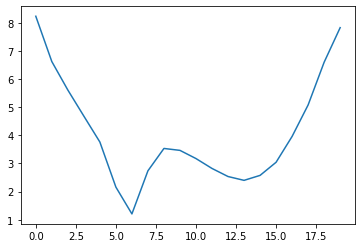

---------------------------------------------------------------------------
Optimized reaction coordinate: [-0.778 -0.575  1.000 -0.100]
This solution has 2 wells and is therefore accepted.
---------------------------------------------------------------------------
---------------------------------------------------------------------------
BEGINNING 3 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[ 0.237 -0.033 -0.325 -0.688] with spectral gap 0.0064 accepted after  12 runs (0.047)
[-0.718  0.025 -0.131 -0.155] with spectral gap 0.0047 accepted after   6 runs (0.024)
[-0.721  0.466  0.785 -0.846] with spectral gap 0.0074 accepted after   6 runs (0.027)
[-0.028 -0.269  0.535 -1.511] with spectral gap 0.0039 accepted after   6 runs (0.026)
[-0.752  0.569  0.702 -2.049] with spectral gap 0.0069 accepted after   6 runs (0.025)
[-0.535 -0.131  0.493 -2.025] with spectral gap 0.0000 accepted after   6 runs (0.027)
[-0.906  0.796 -0.

[ 0.345  4.723  3.007  3.138] with spectral gap 0.0184 accepted after   6 runs (0.026)
[ 0.046  4.207  2.414  2.448] with spectral gap 0.0199 accepted after   6 runs (0.027)
[ 0.532  3.598  1.967  2.333] with spectral gap 0.0189 declined after   6 runs (0.027)
[ 0.831  4.838  2.936  1.889] with spectral gap 0.0201 accepted after   6 runs (0.031)
[ 0.687  4.387  2.552  1.167] with spectral gap 0.0200 accepted after   6 runs (0.034)
[ 0.111  4.671  2.318  0.160] with spectral gap 0.0165 declined after   6 runs (0.030)
[ 0.721  3.496  2.708  0.970] with spectral gap 0.0198 accepted after   6 runs (0.029)
[ 1.174  2.642  2.112  0.536] with spectral gap 0.0194 accepted after   6 runs (0.032)
[ 0.349  1.718  3.170  1.287] with spectral gap 0.0058 declined after   6 runs (0.028)
[ 1.785  2.330  2.171 -0.452] with spectral gap 0.0128 declined after   6 runs (0.025)
[ 2.233  3.455  3.048  0.697] with spectral gap 0.0165 declined after   6 runs (0.030)
[ 0.663  2.228  2.103 -0.053] with spectral

[ 1.308  2.674  0.372  1.657] with spectral gap 0.0141 declined after   6 runs (0.025)
[-0.140  4.007  1.844  0.706] with spectral gap 0.0223 declined after   6 runs (0.026)
[-0.133  3.495  1.358  2.109] with spectral gap 0.0191 declined after   6 runs (0.023)
[ 1.018  3.242  0.635  0.912] with spectral gap 0.0128 declined after   6 runs (0.022)
[-0.238  3.877  0.537  0.896] with spectral gap 0.0193 declined after   6 runs (0.020)
[ 1.061  4.149  1.146  1.347] with spectral gap 0.0283 accepted after   6 runs (0.021)
[ 0.629  3.329  0.562  0.654] with spectral gap 0.0056 declined after   6 runs (0.022)
[ 0.754  4.654  1.812  0.655] with spectral gap 0.0178 declined after   6 runs (0.020)
[ 1.689  4.919  0.732  1.735] with spectral gap 0.0161 declined after   6 runs (0.020)
[ 1.475  4.908  1.342  2.228] with spectral gap 0.0244 declined after   6 runs (0.024)
[ 1.426  3.799  0.507  1.475] with spectral gap 0.0118 declined after   6 runs (0.025)
[ 1.924  5.031  1.237  0.944] with spectral

[ 1.779  3.101  1.768  1.062] with spectral gap 0.0226 declined after   6 runs (0.034)
[ 2.308  2.284  0.357  1.764] with spectral gap 0.0132 declined after   6 runs (0.033)
[ 2.056  2.031  0.587 -0.077] with spectral gap 0.0176 declined after   6 runs (0.031)
[ 0.849  2.837  0.748  0.098] with spectral gap 0.0018 declined after   6 runs (0.030)
[ 1.908  2.326  0.409  0.013] with spectral gap 0.0038 declined after   6 runs (0.027)
[ 0.673  1.552  1.090  1.404] with spectral gap 0.0103 declined after   6 runs (0.029)
[ 0.725  2.991  1.764  0.652] with spectral gap 0.0203 accepted after   6 runs (0.033)
[ 0.395  2.900  1.439  1.149] with spectral gap 0.0216 accepted after   6 runs (0.033)
[ 0.483  2.740  1.086  2.048] with spectral gap 0.0173 accepted after   6 runs (0.030)
[ 0.187  3.179  1.073  1.168] with spectral gap 0.0240 accepted after   6 runs (0.029)
[ 0.345  3.258  1.948  1.202] with spectral gap 0.0203 declined after   6 runs (0.030)
[-0.612  2.362  1.466  1.661] with spectral

[ 0.998  10.020  4.038  1.927] with spectral gap 0.0251 accepted after   6 runs (0.026)
[ 1.627  10.732  4.030  1.509] with spectral gap 0.0239 accepted after   6 runs (0.028)
[ 1.301  11.301  4.413  1.097] with spectral gap 0.0212 declined after   6 runs (0.026)
[ 1.119  10.254  3.599  1.470] with spectral gap 0.0199 declined after   6 runs (0.025)
[ 1.607  11.002  4.043  2.238] with spectral gap 0.0274 accepted after   6 runs (0.024)
[ 1.332  11.523  4.688  2.924] with spectral gap 0.0252 accepted after   6 runs (0.025)
[ 0.569  11.383  4.397  2.684] with spectral gap 0.0253 accepted after   6 runs (0.027)
[ 0.468  10.798  4.461  2.014] with spectral gap 0.0246 accepted after   6 runs (0.025)
[ 0.603  10.612  3.975  2.216] with spectral gap 0.0234 accepted after   6 runs (0.024)
[ 1.221  11.277  4.294  2.897] with spectral gap 0.0270 accepted after   6 runs (0.027)
[ 1.760  11.726  4.637  3.374] with spectral gap 0.0256 declined after   6 runs (0.026)
[ 0.616  11.475  4.097  3.036] w

[-4.841  6.305 -6.100  3.287] with spectral gap 0.0070 accepted after   6 runs (0.021)
[-5.216  5.576 -5.138  2.750] with spectral gap 0.0067 accepted after   6 runs (0.027)
[-5.818  5.678 -5.798  2.429] with spectral gap 0.0065 accepted after   6 runs (0.022)
[-5.978  6.466 -6.012  1.531] with spectral gap 0.0085 accepted after   6 runs (0.022)
[-6.535  5.736 -7.006  0.682] with spectral gap 0.0077 declined after   6 runs (0.022)
[-6.652  6.616 -6.422  1.474] with spectral gap 0.0082 declined after   6 runs (0.020)
[-6.359  7.411 -5.192  1.436] with spectral gap 0.0080 declined after   6 runs (0.021)
[-6.388  6.038 -5.916  0.583] with spectral gap 0.0087 accepted after   6 runs (0.024)
[-6.214  6.294 -6.358  1.123] with spectral gap 0.0085 accepted after   6 runs (0.022)
[-6.935  6.986 -7.070  1.834] with spectral gap 0.0079 accepted after   6 runs (0.023)
[-6.127  7.637 -8.000  1.030] with spectral gap 0.0090 accepted after   6 runs (0.027)
[-5.689  6.938 -8.582  1.118] with spectral

[-14.318  21.389 -6.197  2.682] with spectral gap 0.0058 accepted after   6 runs (0.025)
[-14.172  22.050 -7.166  3.011] with spectral gap 0.0055 accepted after   6 runs (0.028)
[-14.812  21.852 -7.555  3.483] with spectral gap 0.0048 accepted after   6 runs (0.033)
[-15.606  22.627 -8.754  3.873] with spectral gap 0.0044 declined after   6 runs (0.022)
[-13.976  22.443 -7.263  3.324] with spectral gap 0.0059 accepted after   6 runs (0.025)
[-12.794  21.733 -6.984  2.266] with spectral gap 0.0067 accepted after   6 runs (0.020)
[-11.847  20.697 -7.082  2.515] with spectral gap 0.0066 accepted after   6 runs (0.020)
[-13.021  21.039 -6.604  3.445] with spectral gap 0.0061 accepted after   6 runs (0.019)
[-13.444  19.868 -5.918  2.573] with spectral gap 0.0055 accepted after   6 runs (0.021)
[-14.012  20.166 -6.549  3.381] with spectral gap 0.0050 accepted after   6 runs (0.023)
[-13.093  19.800 -5.700  4.417] with spectral gap 0.0055 accepted after   6 runs (0.033)
[-12.198  20.948 -6.3

[ 1.488  2.489 -2.835  0.340] with spectral gap 0.0116 declined after   6 runs (0.024)
[ 2.433  1.272 -2.138 -1.365] with spectral gap 0.0141 declined after   6 runs (0.027)
[ 1.556  2.844 -1.677  0.207] with spectral gap 0.0267 accepted after   6 runs (0.023)
[ 1.033  3.372 -2.500  0.023] with spectral gap 0.0130 declined after   6 runs (0.023)
[ 1.940  2.260 -0.742  0.858] with spectral gap 0.0114 declined after   6 runs (0.023)
[ 0.949  2.283 -1.009 -0.617] with spectral gap 0.0149 declined after   6 runs (0.027)
[ 1.959  2.116 -0.921 -0.298] with spectral gap 0.0118 declined after   6 runs (0.028)
[ 0.759  2.368 -2.665  1.138] with spectral gap 0.0109 declined after   6 runs (0.022)
[ 1.588  2.542 -1.686  0.160] with spectral gap 0.0298 accepted after   6 runs (0.021)
[ 2.384  1.931 -1.823 -0.775] with spectral gap 0.0199 declined after   6 runs (0.025)
[ 1.803  1.950 -1.589 -0.804] with spectral gap 0.0236 declined after   6 runs (0.021)
[ 0.698  3.299 -1.962 -0.312] with spectral

[ 1.905  1.525 -1.322  0.789] with spectral gap 0.0215 declined after  30 runs (0.100)
[ 1.749  1.324 -1.702 -0.651] with spectral gap 0.0201 declined after   6 runs (0.025)
[ 2.355  2.144 -1.170  0.543] with spectral gap 0.0079 declined after   6 runs (0.023)
[ 1.944  1.784 -2.045 -0.544] with spectral gap 0.0228 declined after   6 runs (0.021)
[ 1.770  2.277 -2.151  0.018] with spectral gap 0.0250 declined after   6 runs (0.020)
[ 2.362  2.183 -1.979  0.324] with spectral gap 0.0307 accepted after   6 runs (0.022)
[ 1.556  2.163 -1.686  0.138] with spectral gap 0.0311 accepted after   6 runs (0.021)
[ 1.833  2.809 -2.002  0.288] with spectral gap 0.0302 accepted after   6 runs (0.021)
[ 2.299  3.223 -2.608  0.653] with spectral gap 0.0263 declined after   6 runs (0.021)
[ 1.497  3.590 -1.468  0.267] with spectral gap 0.0163 declined after   6 runs (0.021)
[ 1.200  2.325 -1.739  0.266] with spectral gap 0.0224 declined after   6 runs (0.023)
[ 2.615  2.684 -2.379  0.645] with spectral

[ 1.104  3.635  3.886 -0.457] with spectral gap 0.0127 accepted after   6 runs (0.027)
[ 1.264  4.283  3.333 -1.371] with spectral gap 0.0118 declined after   6 runs (0.028)
[ 1.187  2.692  2.975 -1.233] with spectral gap 0.0099 accepted after   6 runs (0.024)
[ 1.411  2.488  3.525 -1.905] with spectral gap 0.0081 accepted after   6 runs (0.027)
[ 2.056  3.249  4.439 -1.008] with spectral gap 0.0099 accepted after   6 runs (0.028)
[ 1.197  4.224  3.764 -1.889] with spectral gap 0.0105 accepted after   6 runs (0.031)
[ 1.903  3.532  4.196 -1.209] with spectral gap 0.0103 accepted after   6 runs (0.023)
[ 1.116  4.017  3.485 -2.125] with spectral gap 0.0098 accepted after   6 runs (0.033)
[ 1.693  4.989  3.845 -1.633] with spectral gap 0.0117 accepted after   6 runs (0.025)
[ 2.313  4.881  4.053 -2.586] with spectral gap 0.0096 declined after   6 runs (0.029)
[ 2.477  5.987  3.453 -1.124] with spectral gap 0.0110 accepted after   6 runs (0.030)
[ 3.419  5.081  3.261 -2.048] with spectral

[ 2.066  7.513  4.771  0.621] with spectral gap 0.0182 accepted after   6 runs (0.026)
[ 1.704  6.502  5.035  1.602] with spectral gap 0.0202 accepted after   6 runs (0.026)
[ 1.876  5.582  6.032  2.687] with spectral gap 0.0161 declined after   6 runs (0.024)
[ 1.221  5.583  5.061  2.304] with spectral gap 0.0187 accepted after   6 runs (0.025)
[ 0.147  4.759  6.154  3.327] with spectral gap 0.0139 declined after   6 runs (0.027)
[ 1.681  6.550  5.993  1.988] with spectral gap 0.0187 accepted after   6 runs (0.026)
[ 2.292  7.213  6.775  2.224] with spectral gap 0.0185 accepted after   6 runs (0.025)
[ 1.426  6.375  6.437  2.074] with spectral gap 0.0177 accepted after   6 runs (0.025)
[ 1.166  7.333  6.605  2.961] with spectral gap 0.0189 accepted after   6 runs (0.032)
[ 1.528  7.980  6.129  3.724] with spectral gap 0.0188 accepted after   6 runs (0.028)
[ 1.690  7.982  5.780  3.594] with spectral gap 0.0190 accepted after   6 runs (0.027)
[ 0.728  7.881  4.582  3.633] with spectral

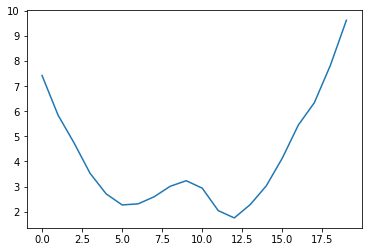

---------------------------------------------------------------------------
This solution has 1 wells and is therefore rejected.
---------------------------------------------------------------------------


In [14]:
sgoop.wells = 2
nfev=0
solutions=[]
wells_found,soln=sgoophopping(iterations=5) # calculating 2 well solution
p=sgoop.md_prob(soln)
plt.figure()
plt.plot(-np.ma.log(p))
plt.show()

while sgoop.wells == wells_found: # iteration for > 2 well solutions, continues while self consistent
    print('---------------------------------------------------------------------------')
    print('Optimized reaction coordinate:',soln)
    print('This solution has',wells_found,'wells and is therefore accepted.')
    print('---------------------------------------------------------------------------')
    solutions.append([soln,sgoop.wells])
    sgoop.wells+=1
    wells_found,soln=sgoophopping(iterations=5)
    p=sgoop.md_prob(soln)
    plt.figure()
    plt.plot(-np.ma.log(p))
    plt.show()
else:
    print('---------------------------------------------------------------------------')
    print('This solution has',wells_found,'wells and is therefore rejected.')
    print('---------------------------------------------------------------------------')

In [15]:
rc = solutions[-1][0]
std = np.std(np.dot(sgoop.data_array,rc))
print('Optimized RC:')
print(rc)
print('Standard deviation (sigma in metad):')
print(std)

Optimized RC:
[-0.778 -0.575  1.000 -0.100]
Standard deviation (sigma in metad):
0.5218433410377148
